# Gene mutation analysis
## Load graph
Parsing GFA file manually, since GfaPy takes a strangely long amount of time reading through it.

In [1]:
import networkx as nx
import matplotlib
from matplotlib import pyplot
from statistics import median

# Loads the new graph
FILENAME = "/home/marcus/PevznerLabBigData/20201014_graph/noseq.gfa"

# We ignore directionality for right now
graph = nx.Graph()

with open(FILENAME, "r") as gfafile:
    for line in gfafile:
        if line[0] == "S":
            parts = line.strip().split("\t")
            node_name = parts[1]
            node_len = None
            node_cov = None
            extra_data = parts[3:]
            for tag in extra_data:
                if tag.startswith("LN:i:"):
                    if node_len is None:
                        node_len = int(tag[5:])
                    else:
                        raise ValueError("Duplicate length for node {}".format(node_name))
                elif tag.startswith("dp:i:"):
                    if node_cov is None:
                        node_cov = int(tag[5:])
                    else:
                        raise ValueError("Duplicate coverage for node {}".format(node_name))
            graph.add_node(node_name, length=node_len, cov=node_cov)
        elif line[0] == "L":
            parts = line.strip().split("\t")
            src = parts[1]
            snk = parts[3]
            # Ignore directionality for just right now; this means that some links will be "repeated" (for
            # the new graph this means that the NX representation has 484 less links)
            graph.add_edge(src, snk)

node2len = nx.get_node_attributes(graph, "length")
node2cov = nx.get_node_attributes(graph, "cov")
            
print("Graph contains {} edges (represented as GFA segments).".format(graph.number_of_nodes()))
print("Graph contains {} links between edges (ignoring directionality for now).".format(graph.number_of_edges()))
print("Graph contains {} connected components.".format(nx.number_connected_components(graph)))

Graph contains 36260 edges (represented as GFA segments).
Graph contains 40545 links between edges (ignoring directionality for now).
Graph contains 8655 connected components.


## Compute "real" coverage based on pileup data

Go through pileup for each of the edges, compute number of mapped reads at each position, and average over all positions in the sequence. Will be more accurate than the value reported in the graph, at least from the perspective of the data we're looking at.

In [2]:
from statistics import mean
from collections import defaultdict

edgenum2coverages = defaultdict(list)
with open("/home/marcus/PevznerLabBigData/20201014_graph/5xdata-pileup.txt", "r") as pf:
    for line in pf:
        split = line.split("\t")
        lineheader = split[0]
        edgenum = lineheader.split("_")[1]
        position_coverage = int(split[3])
        edgenum2coverages[edgenum].append(position_coverage)
        
for edge in edgenum2coverages:
    print("Edge {} (length {}): {} positions in pileup. Average coverage = {:.2f}. Median coverage = {}.".format(
        edge, node2len[edge], len(edgenum2coverages[edge]), mean(edgenum2coverages[edge]),
        median(edgenum2coverages[edge])
    ))

Edge 166 (length 1302342): 1302342 positions in pileup. Average coverage = 527.11. Median coverage = 527.0.
Edge 6018 (length 2232606): 2232606 positions in pileup. Average coverage = 515.58. Median coverage = 507.0.
Edge 7998 (length 1634900): 1634900 positions in pileup. Average coverage = 796.41. Median coverage = 786.0.


## Visualize mutation spectra

###  Visualizing raw number of discordant aligned reads

For each position in the sequence, find the number of matches (`.` or `,` characters) and return

\begin{equation}
\text{Number of aligned reads} - \text{Number of matching reads}
\end{equation}

In [10]:
from collections import defaultdict
edge2mutations = defaultdict(list)
edge2pos = defaultdict(list)
with open("/home/marcus/PevznerLabBigData/20201014_graph/5xdata-pileup.txt", "r") as pf:
    for line in pf:
        split = line.split("\t")
        lineheader = split[0]
        edgenum = lineheader.split("_")[1]
        num_matches = split[4].count(".") + split[4].count(",")
        edge2mutations[edgenum].append(int(split[3]) - num_matches)
        edge2pos[edgenum].append(int(split[1]))

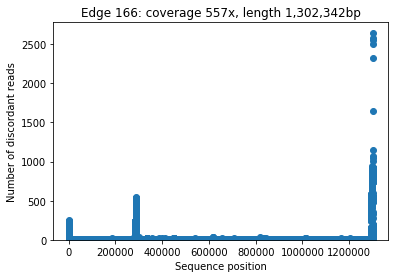

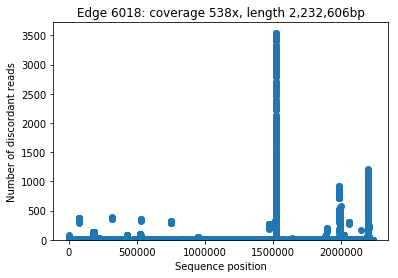

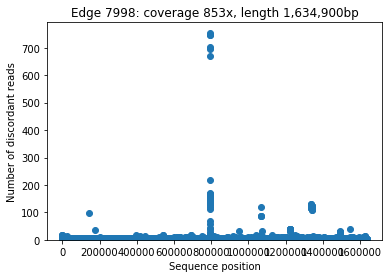

In [12]:
for e in edge2mutations.keys():
    pyplot.scatter(x=edge2pos[e], y=edge2mutations[e])
    pyplot.title("Edge {}: coverage {:,}x, length {:,}bp".format(e, node2cov[e], node2len[e]))
    pyplot.xlabel("Sequence position")
    pyplot.ylabel("Number of discordant reads")
    pyplot.ylim(bottom=0)
    pyplot.show()

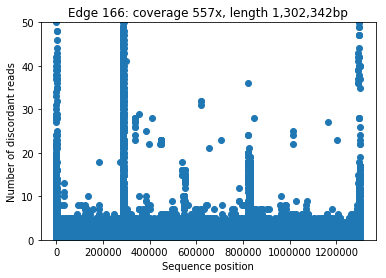

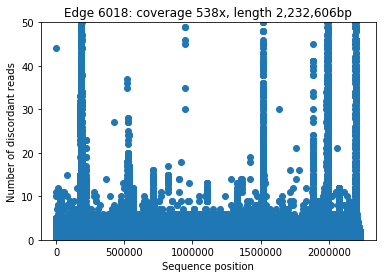

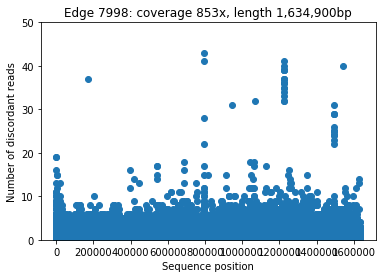

In [13]:
# Spectra but zoomed in to [0, 50]
for e in edge2mutations.keys():
    pyplot.scatter(x=edge2pos[e], y=edge2mutations[e])
    pyplot.title("Edge {}: coverage {:,}x, length {:,}bp".format(e, node2cov[e], node2len[e]))
    pyplot.xlabel("Sequence position")
    pyplot.ylabel("Number of discordant reads")
    pyplot.ylim(bottom=0, top=50)
    pyplot.show()

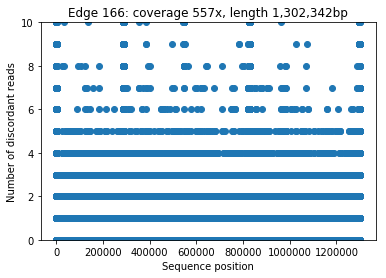

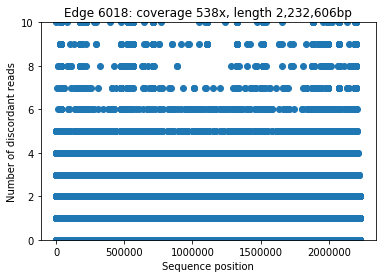

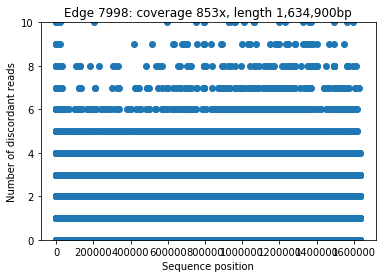

In [9]:
# Spectra but zoomed in to [0, 10]
for e in edge2mutations.keys():
    pyplot.scatter(x=edge2pos[e], y=edge2mutations[e])
    pyplot.title("Edge {}: coverage {:,}x, length {:,}bp".format(e, node2cov[e], node2len[e]))
    pyplot.xlabel("Sequence position")
    pyplot.ylabel("Number of discordant reads")
    pyplot.ylim(bottom=0, top=10)
    pyplot.show()

## Go through predicted genes and compute mutation frequencies at 1st, 2nd, 3rd positions

### Compute coverage and match frequency at every position
From these two values we can do quite a few different things -- there are many ways to define a "mutation" / "variant" / etc. Makes sense to load this stuff in all at once and then mess around with it afterwards, rather than repeatedly parsing the massive pileup file.

In [7]:
from collections import defaultdict
# "Coverage": number of reads aligning to this position
edge2pos2cov = defaultdict(dict)
# "Matches": number of matching reads (i.e. those matching the assembled sequence) at this position
edge2pos2matches = defaultdict(dict)
with open("/home/marcus/PevznerLabBigData/20201014_graph/5xdata-pileup.txt", "r") as pf:
    for line in pf:
        split = line.split("\t")
        lineheader = split[0]
        edgenum = lineheader.split("_")[1]
        num_matches = split[4].count(".") + split[4].count(",")
        
        # use 1-indexed coordinates, since MetaGeneMark does in its output (as far as I can tell).
        # Fortunately pileup also uses 1-indexed coordinates.
        # The reason we store this stuff in dicts of dicts (rather than just dicts of lists, where
        # the 0th entry is the 1st position, the 1st entry is the 2nd position, etc.) is because we don't
        # really need to save the memory right now, and I want to avoid off-by-1 errors as much as humanly
        # possible right now.
        pos = int(split[1])
        edge2pos2cov = int(split[3])
        edge2pos2matches = num_matches

### Utility functions

In [36]:
def histogram_of_123(one, two, three, title, xlabel="Modulo position within gene", ylabel="Frequency"):
    pyplot.bar(x=[1, 2, 3], height=[one, two, three])
    pyplot.title(title)
    pyplot.xlabel(xlabel)
    pyplot.ylabel(ylabel)
    pyplot.show()
    
def get_pos_interval_from_gene(gene):
    try:
        start = int(gene.LeftEnd)
    except ValueError:
        # Account for the "<2" left end coordinate in one of the genes predicted
        start = int(gene.LeftEnd[1:])
    end = int(gene.RightEnd)

    if gene.Strand == "-":
        return range(end, start - 1, -1)
    elif gene.Strand == "+":
        return range(start, end + 1)
    else:
        raise ValueError("Unknown strand: {}".format(gene.Strand))

### Draw histograms showing frequencies of exactly 1 "mutation" at 1/2/3 positions

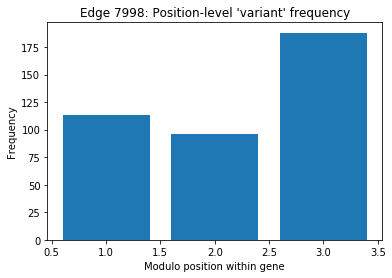

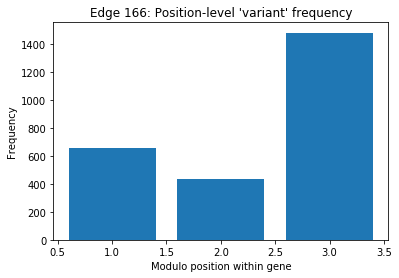

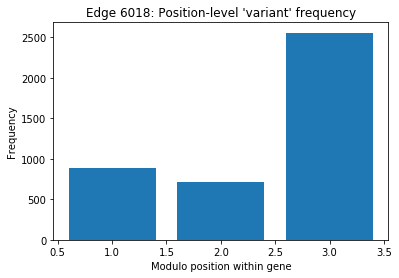

In [37]:
# This is length in DNA, not amino acids
MIN_GENE_LENGTH = 0
import pandas as pd
from statistics import mean

for edge in ["7998", "166", "6018"]:
    mgm = pd.read_csv(
        "/home/marcus/PevznerLabBigData/20201014_graph/{}_mgm_genes.txt".format(edge),
        sep="\s+", skiprows=[1], index_col=0, header=0, names=["Strand", "LeftEnd", "RightEnd", "Length", "Class"]
    )

    # Mutation rates at modulo positions 1, 2, 3 in a gene within the genome (goes 1, 2, 3, 1, 2, 3, ...)
    m1 = []
    m2 = []
    m3 = []
    for gene in mgm.itertuples():
        if gene.Length < MIN_GENE_LENGTH:
            # print("Gene {} has len {}, less than {}.".format(gene.Index, gene.Length, MIN_GENE_LENGTH))
            continue
        i = 1
        for pos in get_pos_interval_from_gene(gene):
            mutfreq = edge2pos2mutfreq[edge][pos]
            if i == 1:
                m1.append(mutfreq)
                i = 2
            elif i == 2:
                m2.append(mutfreq)
                i = 3
            elif i == 3:
                m3.append(mutfreq)
                i = 1
            else:
                raise ValueError("Marcus forgot how modulos work, go yell at him pls")
                
        if i != 1:
            raise ValueError("Gene length not divisible by 3.")
        
        #print("1s:", sorted(m1))
        #print("Edge {}, gene {}: {} | {} | {}".format(edge, gene.Index, *[sum(m) for m in [m1, m2, m3]]))
    assert len(m1) == len(m2) == len(m3)
    histogram_of_123(
        sum(m1), sum(m2), sum(m3),
        "Edge {}: Position-level 'variant' frequency".format(edge)
    )